Significancia:

$$Z = \frac{S}{\sqrt{S+B}}$$

In [1]:
import awkward as ak
import pandas as pd
import numpy as np
import vector
from coffea.nanoevents import NanoEventsFactory
from coffea.nanoevents import NanoAODSchema, DelphesSchema
import mplhep as hep
import matplotlib.pyplot as plt
import seaborn as sns
import DM_HEP_AN as dm
from math import pi
from funcs import *
hep.style.use("CMS")
#%matplotlib inline
plt.ioff()

In [2]:
# Signal
cases = ["gSq_only","gSg1_only", "gSg2_only_y0y0", "gSg_only"]
data = {}
for i in cases:
    csvFile = [f"./sim_outputs/csv/DM_{i}_1.csv", f"./sim_outputs/csv/DM_{i}_2.csv"]
    data[i] = [pd.read_csv(j) for j in csvFile]

In [3]:
print("Número de Eventos: ",[[data[i][j].shape[0] for j in range(2)] for i in cases])

Número de Eventos:  [[50000, 50000], [50000, 50000], [50000, 50000], [50000, 50000]]


In [4]:
# Background
csvFile = "./background/ZpJets.csv"
data_ZpJ = pd.read_csv(csvFile)
csvFile = "./background/WpJets.csv"
data_WpJ = pd.read_csv(csvFile)

Cross-section

In [5]:
CSs = {}
for i in cases:
    CSs[f"{i}"] = []
    CSs[f"error{i}"] = []

In [6]:
outFile = "sim_outputs/log.out"
outData = open(outFile, "r")
outText = outData.read()
outData.close()

In [7]:
indexCS = outText.find('Cross-section :   ')
indexPM = outText.find(' +- ', indexCS)
indexPB = outText.find(' pb', indexCS)
counter = 0
repCount = True
run = 1
while indexCS != -1:
    if repCount:
        repCount = False
    else:
        #print("Cross-section: ", outText[indexCS+18:indexPM])
        #print("errorbar :", outText[indexPM+4:indexPB])
        CSs[f"{cases[counter]}"].append(float(outText[indexCS+18:indexPM]))
        CSs[f"error{cases[counter]}"].append(float(outText[indexPM+4:indexPB]))
        match run:
            case 1:
                run = 2
            case 2:
                run = 1
                counter +=1
        repCount = True
    indexCS = outText.find('Cross-section :   ', indexCS+1)
    indexPM = outText.find(' +- ', indexCS)
    indexPB = outText.find(' pb', indexCS)
print(counter)

4


In [8]:
CSs

{'gSq_only': [0.0008833, 3.692e-05],
 'errorgSq_only': [1.722e-06, 7.012e-08],
 'gSg1_only': [41.16, 6.965],
 'errorgSg1_only': [0.06192, 0.01127],
 'gSg2_only_y0y0': [0.002104, 0.0001629],
 'errorgSg2_only_y0y0': [3.224e-06, 2.454e-07],
 'gSg_only': [41.2, 6.972],
 'errorgSg_only': [0.06122, 0.01005]}

In [9]:
# fictious cross section
newCS = 0.1 # pb (100 fb)
CSs['gSq_only'] = [newCS, newCS]
CSs['gSg2_only_y0y0'] = [newCS, newCS]

Significance

In [10]:
def find_significance(cases, SG, BG, cut_var,
                      mass_points=2, use_weights=False, SG_weights={},
                      BG_weights=[], size=100, set_lims=False,
                      lims=(0,1), BG_with_cases=False):
    
    var_values = {}; Z = {} # outputs
    nBG = len(BG) # number of backgrounds

    if not use_weights:
        BG_weights = np.ones(nBG)
    
    for i in cases:
        var_values[i] = []; Z[i] = []

        if not use_weights:
            SG_weights[i] = []
        
        for j in range(mass_points):
            
            if not use_weights:
                SG_weights[i].append(1.0)
            
            # Limits            
            infLim = SG[i][j][cut_var].min()
            supLim = SG[i][j][cut_var].max()
            if set_lims:
                infLim = lims[0] if infLim < lims[0] else infLim
                supLim = lims[1] if supLim > lims[1] else supLim
            
            var_values[i].append(np.linspace(infLim, supLim, size))
            Z[i].append(np.zeros(len(var_values[i][j])))

            for k in range(len(var_values[i][j])):
                # Signal
                S = SG[i][j][SG[i][j][cut_var] > var_values[i][j][k]].shape[0] * SG_weights[i][j]
                # Background
                B = sum(
                    [BG[ii][BG[ii][cut_var] > var_values[i][j][k]].shape[0] * BG_weights[ii] for ii in range(len(BG))]
                )

                Z[i][j][k] = S/np.sqrt(S+B)
    
    return Z, var_values

In [11]:
Z, pt_values = find_significance(cases, data, [data_WpJ, data_ZpJ], cut_var='jet_pt0')

/tmp/ipykernel_5604/1467168725.py:41: RuntimeWarning: invalid value encountered in double_scalars
  Z[i][j][k] = S/np.sqrt(S+B)


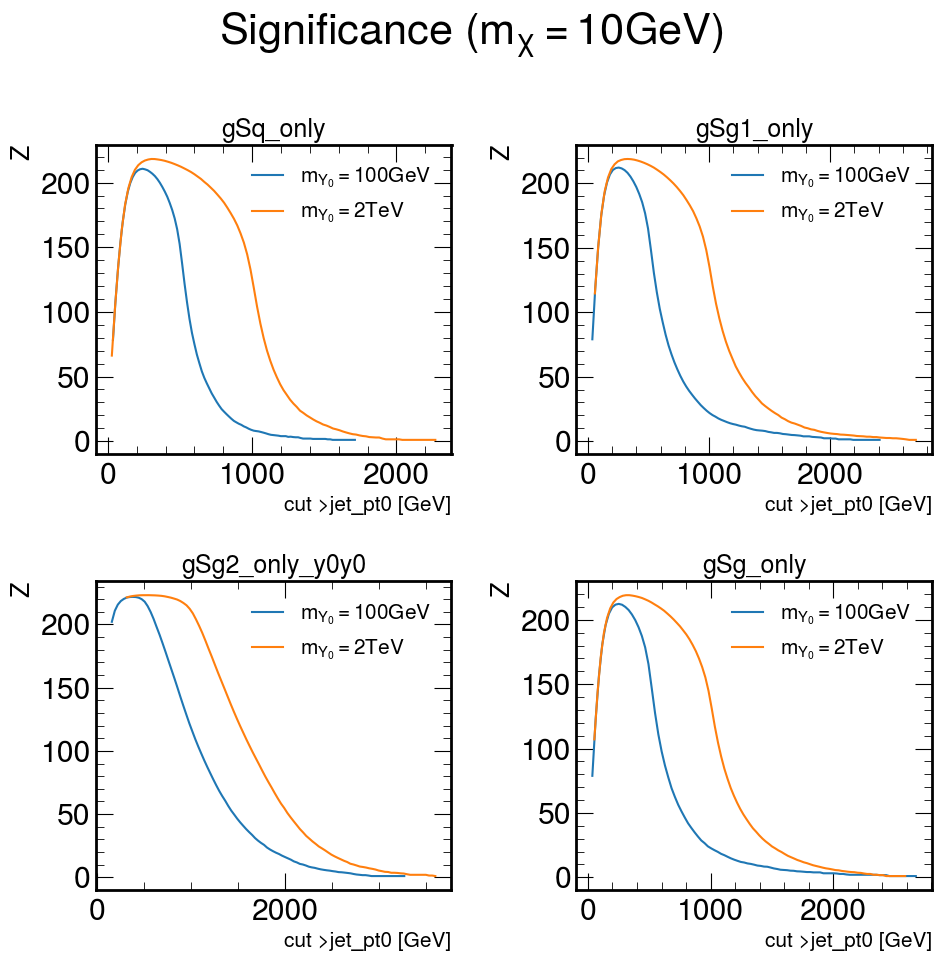

In [12]:
fig, ax = plt.subplots(2,2)

fig.suptitle(r"Significance ($m_{\chi} = 10$GeV)")

for i in range(2):
    ax[0,0].plot(pt_values[cases[0]][i], Z[cases[0]][i])
    ax[0,1].plot(pt_values[cases[1]][i], Z[cases[1]][i])
    ax[1,0].plot(pt_values[cases[2]][i], Z[cases[2]][i])
    ax[1,1].plot(pt_values[cases[3]][i], Z[cases[3]][i])
    ax[0,0].set_title(cases[0], fontsize=18)
    ax[0,1].set_title(cases[1], fontsize=18)
    ax[1,0].set_title(cases[2], fontsize=18)
    ax[1,1].set_title(cases[3], fontsize=18)

for i in range(2):
    for j in range(2):
        ax[i,j].legend([r"$m_{Y_{0}}=100$GeV",r"$m_{Y_{0}}=2$TeV"],fontsize=15)
        ax[i,j].set_xlabel("cut >jet_pt0 [GeV]",fontsize=15)
        ax[i,j].set_ylabel("Z",fontsize=18)
        #ax[i,j].set_xlim(0,1000)

fig.tight_layout()
plt.show()

Acotamos el area de busqueda

In [13]:
Z, pt_values = find_significance(cases, data, [data_WpJ, data_ZpJ], cut_var='jet_pt0', set_lims=True, lims=(0,1000), size=500)

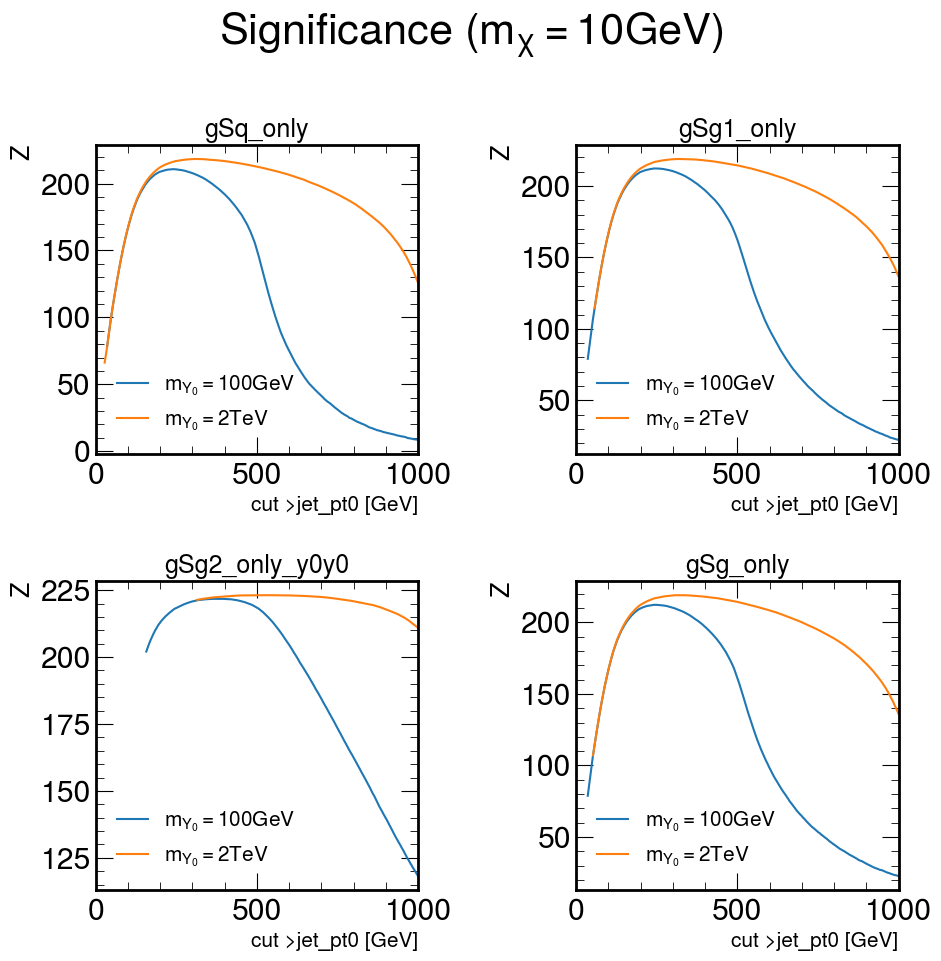

In [14]:
fig, ax = plt.subplots(2,2)

fig.suptitle(r"Significance ($m_{\chi} = 10$GeV)")

for i in range(2):
    ax[0,0].plot(pt_values[cases[0]][i], Z[cases[0]][i])
    ax[0,1].plot(pt_values[cases[1]][i], Z[cases[1]][i])
    ax[1,0].plot(pt_values[cases[2]][i], Z[cases[2]][i])
    ax[1,1].plot(pt_values[cases[3]][i], Z[cases[3]][i])
    ax[0,0].set_title(cases[0], fontsize=18)
    ax[0,1].set_title(cases[1], fontsize=18)
    ax[1,0].set_title(cases[2], fontsize=18)
    ax[1,1].set_title(cases[3], fontsize=18)

for i in range(2):
    for j in range(2):
        ax[i,j].legend([r"$m_{Y_{0}}=100$GeV",r"$m_{Y_{0}}=2$TeV"],fontsize=15)
        ax[i,j].set_xlabel("cut >jet_pt0 [GeV]",fontsize=15)
        ax[i,j].set_ylabel("Z",fontsize=18)
        ax[i,j].set_xlim(0,1000)
        #ax[i,j].set_ylim()

fig.tight_layout()
plt.show()

Entonces aquí buscamos el valor máximo de la significancia para cada caso

In [15]:
def get_cuts(cases, Z, var_values, cut_var,
             var_unit, massLabels, printResults=False):
    massPoints = len(massLabels)
    cuts = {}
    for i in cases:
        if printResults: print("case :", i)
        cuts[i] = []
        for j in range(massPoints):
            maxZ = max(Z[i][j])
            max_index = Z[i][j].argmax()
            cut = var_values[i][j][max_index]
            cuts[i].append(cut)
            if printResults:
                print(f"\tmass point: {massLabels[j]}")
                print(f"\t\tmax significance: {maxZ}")
                print(f"\t\tcut: {cut_var} > {round(cut, 3)}{var_unit}")
    return cuts

In [16]:
cuts = get_cuts(cases, Z, pt_values, "jet_pt0", "GeV", ["my0=100GeV", "my0=2TeV"], printResults=True)

case : gSq_only
	mass point: my0=100GeV
		max significance: 210.71852389371332
		cut: jet_pt0 > 240.506GeV
	mass point: my0=2TeV
		max significance: 218.32265061813575
		cut: jet_pt0 > 314.26GeV
case : gSg1_only
	mass point: my0=100GeV
		max significance: 212.34449048784563
		cut: jet_pt0 > 246.635GeV
	mass point: my0=2TeV
		max significance: 218.9567558097338
		cut: jet_pt0 > 317.972GeV
case : gSg2_only_y0y0
	mass point: my0=100GeV
		max significance: 221.81015902448894
		cut: jet_pt0 > 381.715GeV
	mass point: my0=2TeV
		max significance: 223.15056974287228
		cut: jet_pt0 > 534.998GeV
case : gSg_only
	mass point: my0=100GeV
		max significance: 212.37759453978484
		cut: jet_pt0 > 246.543GeV
	mass point: my0=2TeV
		max significance: 219.09379720425275
		cut: jet_pt0 > 320.076GeV


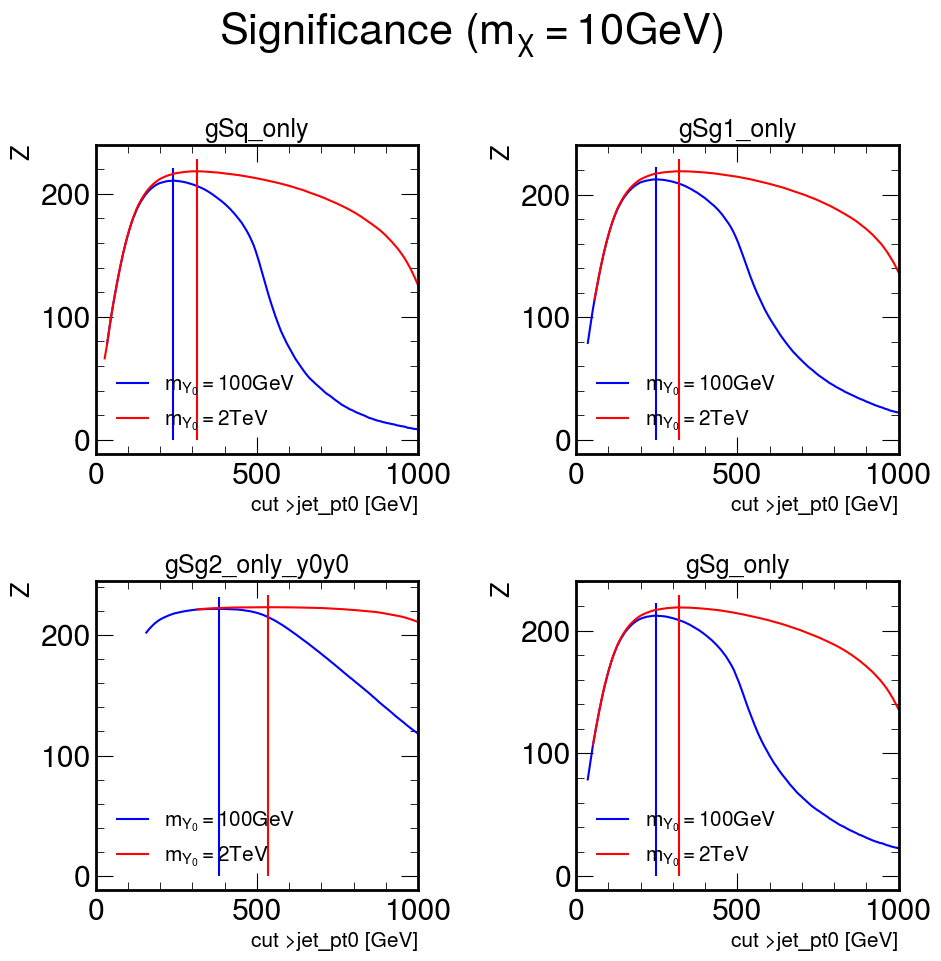

In [17]:
fig, ax = plt.subplots(2,2)

fig.suptitle(r"Significance ($m_{\chi} = 10$GeV)")

colors = ["b","r"]
labels = [r"$m_{Y_{0}}=100$GeV",r"$m_{Y_{0}}=2$TeV"]

for i in range(2):
    ax[0,0].plot(pt_values[cases[0]][i], Z[cases[0]][i],color=colors[i], label=labels[i])
    ax[0,1].plot(pt_values[cases[1]][i], Z[cases[1]][i],color=colors[i], label=labels[i])
    ax[1,0].plot(pt_values[cases[2]][i], Z[cases[2]][i],color=colors[i], label=labels[i])
    ax[1,1].plot(pt_values[cases[3]][i], Z[cases[3]][i],color=colors[i], label=labels[i])
    ax[0,0].set_title(cases[0], fontsize=18)
    ax[0,1].set_title(cases[1], fontsize=18)
    ax[1,0].set_title(cases[2], fontsize=18)
    ax[1,1].set_title(cases[3], fontsize=18)
    ax[0,0].vlines(cuts[cases[0]][i], ymin=0, ymax=max(Z[cases[0]][i])+10,color=colors[i])
    ax[0,1].vlines(cuts[cases[1]][i], ymin=0, ymax=max(Z[cases[1]][i])+10,color=colors[i])
    ax[1,0].vlines(cuts[cases[2]][i], ymin=0, ymax=max(Z[cases[2]][i])+10,color=colors[i])
    ax[1,1].vlines(cuts[cases[3]][i], ymin=0, ymax=max(Z[cases[3]][i])+10,color=colors[i])

for i in range(2):
    for j in range(2):
        ax[i,j].legend(fontsize=15)
        ax[i,j].set_xlabel("cut >jet_pt0 [GeV]",fontsize=15)
        ax[i,j].set_ylabel("Z",fontsize=18)
        ax[i,j].set_xlim(0,1000)
        #ax[i,j].set_ylim()

fig.tight_layout()
plt.show()

In [18]:
cut_data1 = {}
dataWpJ_cut1 = {}
dataZpJ_cut1 = {}
for i in cases:
    cut_data1[i] = []
    dataWpJ_cut1[i] = []
    dataZpJ_cut1[i] = []
    for j in range(2):
        cut_data1[i].append(data[i][j][data[i][j]['jet_pt0'] > cuts[i][j]].copy())
        dataWpJ_cut1[i].append(data_WpJ[data_WpJ['jet_pt0'] > cuts[i][j]].copy())
        dataZpJ_cut1[i].append(data_ZpJ[data_ZpJ['jet_pt0'] > cuts[i][j]].copy())

In [19]:
print("Número de Eventos (original): ",[[data[i][j].shape[0] for j in range(2)] for i in cases])
print("Número de Eventos Background WpJets + ZpJets (original): ",[data_WpJ.shape[0], data_ZpJ.shape[0]])
print("Número de Eventos (cut1): ",[[cut_data1[i][j].shape[0] for j in range(2)] for i in cases])
print("Número de Eventos Background WpJets (cut1): ",[[dataWpJ_cut1[i][j].shape[0] for j in range(2)] for i in cases])
print("Número de Eventos Background ZpJets (cut1): ",[[dataZpJ_cut1[i][j].shape[0] for j in range(2)] for i in cases])

Número de Eventos (original):  [[50000, 50000], [50000, 50000], [50000, 50000], [50000, 50000]]
Número de Eventos Background WpJets + ZpJets (original):  [1237914, 1197048]
Número de Eventos (cut1):  [[46977, 48660], [47466, 48898], [49683, 49890], [47481, 48934]]
Número de Eventos Background WpJets (cut1):  [[1216, 422], [1122, 399], [204, 47], [1122, 389]]
Número de Eventos Background ZpJets (cut1):  [[1508, 594], [1379, 576], [284, 47], [1380, 561]]


Observamos la diferencia al aplicar los pesos, teniendo que

$$W = \frac{N_{fisicos}}{N_{MG+Pythia}}$$

In [20]:
Weights = pd.read_csv("BGweigths.csv").to_dict()
# Luminosity to normalize
lum = 1 # fb-1

for i in cases:
    Weights[i] = []
    for j in range(2):
        Weights[i].append(CSs[i][j]*1000*lum/data[i][j].shape[0])

In [21]:
Weights['WpJets'] = Weights['WpJets'][0]
Weights['ZpJets'] = Weights['ZpJets'][0]
Weights.pop('Unnamed: 0')

{0: 0}

In [22]:
Weights

{'WpJets': 25.796083842119348,
 'ZpJets': 7.412985945425747,
 'gSq_only': [0.002, 0.002],
 'gSg1_only': [0.8232, 0.1393],
 'gSg2_only_y0y0': [0.002, 0.002],
 'gSg_only': [0.824, 0.13944]}

In [23]:
Z, pt_values = find_significance(cases, data, [data_WpJ, data_ZpJ],
                                 cut_var='jet_pt0', use_weights=True, SG_weights=Weights,
                                 BG_weights=[Weights['WpJets'], Weights['ZpJets']])

/tmp/ipykernel_5604/1467168725.py:41: RuntimeWarning: invalid value encountered in double_scalars
  Z[i][j][k] = S/np.sqrt(S+B)


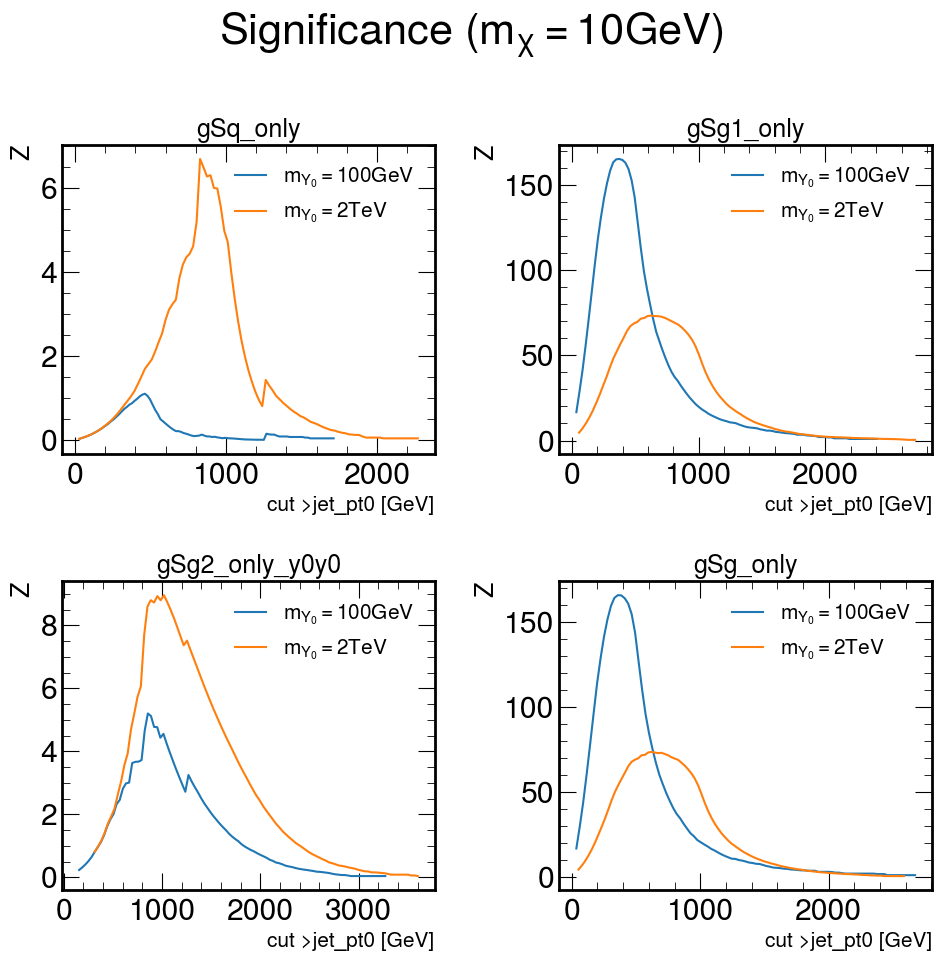

In [24]:
fig, ax = plt.subplots(2,2)

fig.suptitle(r"Significance ($m_{\chi} = 10$GeV)")

for i in range(2):
    ax[0,0].plot(pt_values[cases[0]][i], Z[cases[0]][i])
    ax[0,1].plot(pt_values[cases[1]][i], Z[cases[1]][i])
    ax[1,0].plot(pt_values[cases[2]][i], Z[cases[2]][i])
    ax[1,1].plot(pt_values[cases[3]][i], Z[cases[3]][i])
    ax[0,0].set_title(cases[0], fontsize=18)
    ax[0,1].set_title(cases[1], fontsize=18)
    ax[1,0].set_title(cases[2], fontsize=18)
    ax[1,1].set_title(cases[3], fontsize=18)

for i in range(2):
    for j in range(2):
        ax[i,j].legend([r"$m_{Y_{0}}=100$GeV",r"$m_{Y_{0}}=2$TeV"],fontsize=15)
        ax[i,j].set_xlabel("cut >jet_pt0 [GeV]",fontsize=15)
        ax[i,j].set_ylabel("Z",fontsize=18)
        #ax[i,j].set_xlim(0,2000)

fig.tight_layout()
plt.show()

Acotamos el rango de busqueda

In [25]:
Z, pt_values = find_significance(cases, data, [data_WpJ, data_ZpJ],
                                 cut_var='jet_pt0', use_weights=True, SG_weights=Weights,
                                 BG_weights=[Weights['WpJets'], Weights['ZpJets']],
                                 set_lims=True, lims=(0,1500), size=500)

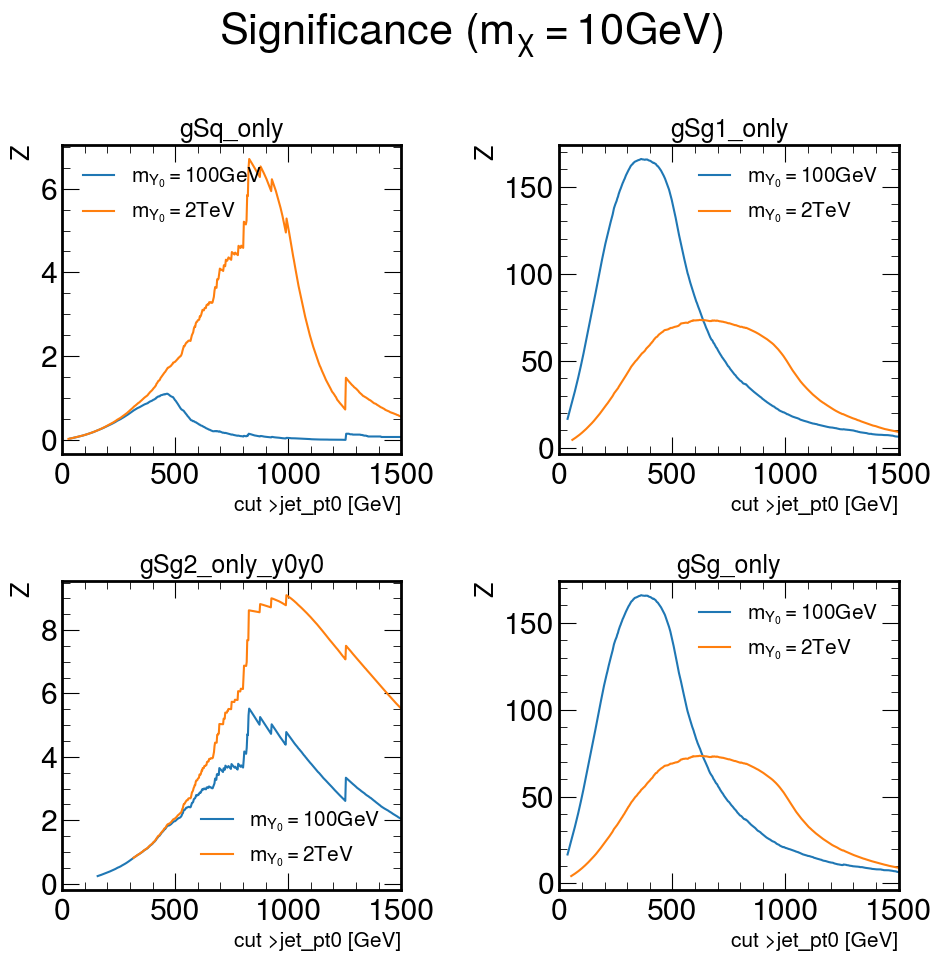

In [26]:
fig, ax = plt.subplots(2,2)

fig.suptitle(r"Significance ($m_{\chi} = 10$GeV)")

for i in range(2):
    ax[0,0].plot(pt_values[cases[0]][i], Z[cases[0]][i])
    ax[0,1].plot(pt_values[cases[1]][i], Z[cases[1]][i])
    ax[1,0].plot(pt_values[cases[2]][i], Z[cases[2]][i])
    ax[1,1].plot(pt_values[cases[3]][i], Z[cases[3]][i])
    ax[0,0].set_title(cases[0], fontsize=18)
    ax[0,1].set_title(cases[1], fontsize=18)
    ax[1,0].set_title(cases[2], fontsize=18)
    ax[1,1].set_title(cases[3], fontsize=18)

for i in range(2):
    for j in range(2):
        ax[i,j].legend([r"$m_{Y_{0}}=100$GeV",r"$m_{Y_{0}}=2$TeV"],fontsize=15)
        ax[i,j].set_xlabel("cut >jet_pt0 [GeV]",fontsize=15)
        ax[i,j].set_ylabel("Z",fontsize=18)
        ax[i,j].set_xlim(0,1500)

fig.tight_layout()
plt.show()

In [27]:
cuts = get_cuts(cases, Z, pt_values, "jet_pt0", "GeV", ["my0=100GeV", "my0=2TeV"], printResults=True)

case : gSq_only
	mass point: my0=100GeV
		max significance: 1.1084028166475954
		cut: jet_pt0 > 464.101GeV
	mass point: my0=2TeV
		max significance: 6.705238399441048
		cut: jet_pt0 > 827.371GeV
case : gSg1_only
	mass point: my0=100GeV
		max significance: 165.83153729945084
		cut: jet_pt0 > 361.721GeV
	mass point: my0=2TeV
		max significance: 73.47941988387015
		cut: jet_pt0 > 621.052GeV
case : gSg2_only_y0y0
	mass point: my0=100GeV
		max significance: 5.521854071278237
		cut: jet_pt0 > 827.173GeV
	mass point: my0=2TeV
		max significance: 9.101481602738573
		cut: jet_pt0 > 992.03GeV
case : gSg_only
	mass point: my0=100GeV
		max significance: 165.89146244995501
		cut: jet_pt0 > 361.629GeV
	mass point: my0=2TeV
		max significance: 73.46449060921248
		cut: jet_pt0 > 620.927GeV


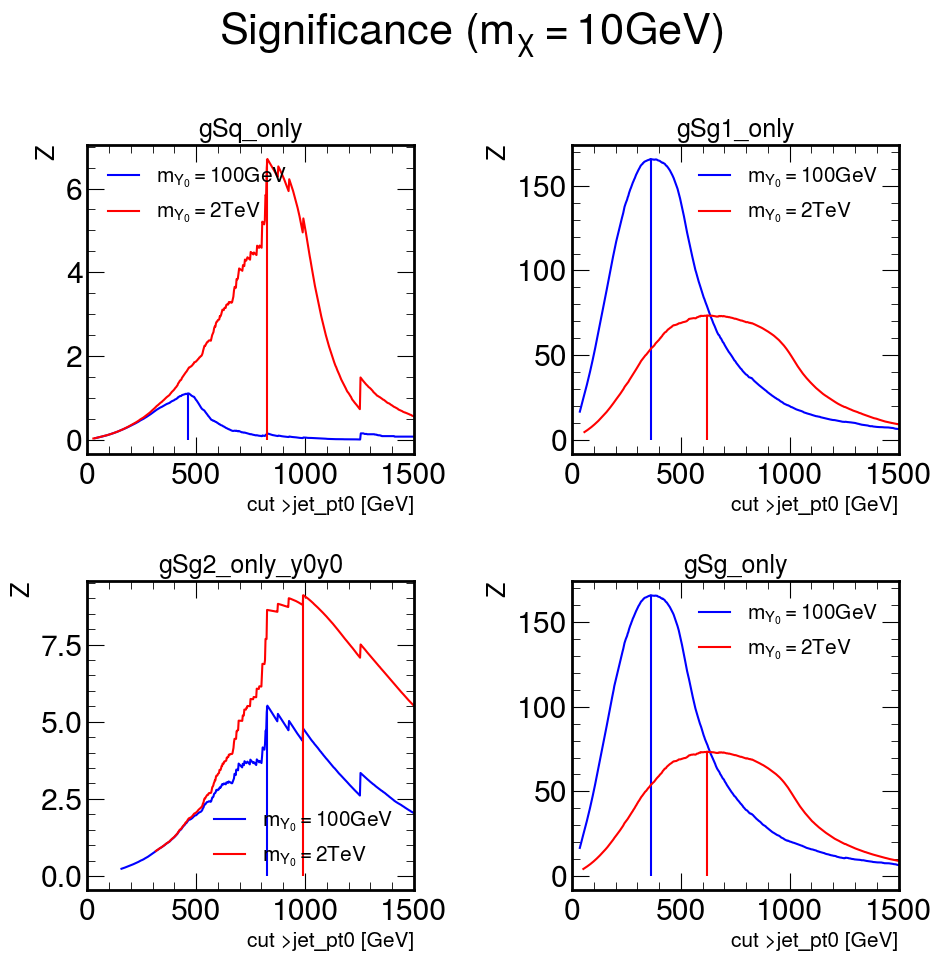

In [28]:
fig, ax = plt.subplots(2,2)

fig.suptitle(r"Significance ($m_{\chi} = 10$GeV)")

colors = ["b","r"]
labels = [r"$m_{Y_{0}}=100$GeV",r"$m_{Y_{0}}=2$TeV"]

for i in range(2):
    ax[0,0].plot(pt_values[cases[0]][i], Z[cases[0]][i],color=colors[i], label=labels[i])
    ax[0,1].plot(pt_values[cases[1]][i], Z[cases[1]][i],color=colors[i], label=labels[i])
    ax[1,0].plot(pt_values[cases[2]][i], Z[cases[2]][i],color=colors[i], label=labels[i])
    ax[1,1].plot(pt_values[cases[3]][i], Z[cases[3]][i],color=colors[i], label=labels[i])
    ax[0,0].set_title(cases[0], fontsize=18)
    ax[0,1].set_title(cases[1], fontsize=18)
    ax[1,0].set_title(cases[2], fontsize=18)
    ax[1,1].set_title(cases[3], fontsize=18)
    ax[0,0].vlines(cuts[cases[0]][i], ymin=0, ymax=max(Z[cases[0]][i]),color=colors[i])
    ax[0,1].vlines(cuts[cases[1]][i], ymin=0, ymax=max(Z[cases[1]][i]),color=colors[i])
    ax[1,0].vlines(cuts[cases[2]][i], ymin=0, ymax=max(Z[cases[2]][i]),color=colors[i])
    ax[1,1].vlines(cuts[cases[3]][i], ymin=0, ymax=max(Z[cases[3]][i]),color=colors[i])

for i in range(2):
    for j in range(2):
        ax[i,j].legend(fontsize=15)
        ax[i,j].set_xlabel("cut >jet_pt0 [GeV]",fontsize=15)
        ax[i,j].set_ylabel("Z",fontsize=18)
        ax[i,j].set_xlim(0,1500)

fig.tight_layout()
plt.show()

In [29]:
cut_data2 = {}
dataWpJ_cut2 = {}
dataZpJ_cut2 = {}
for i in cases:
    cut_data2[i] = []
    dataWpJ_cut2[i] = []
    dataZpJ_cut2[i] = []
    for j in range(2):
        #cut_data2[i].append(data[i][j][data[i][j]['jet_pt0'] > cuts[i][j]].copy())
        #dataWpJ_cut2[i].append(data_WpJ[data_WpJ['jet_pt0'] > cuts[i][j]].copy())
        #dataZpJ_cut2[i].append(data_ZpJ[data_ZpJ['jet_pt0'] > cuts[i][j]].copy())
        cut_data2[i].append(data[i][j][data[i][j]['jet_pt0'] > 300].copy()) # jet_pt0 > 300GeV
        dataWpJ_cut2[i].append(data_WpJ[data_WpJ['jet_pt0'] > 300].copy()) # jet_pt0 > 300GeV
        dataZpJ_cut2[i].append(data_ZpJ[data_ZpJ['jet_pt0'] > 300].copy()) # jet_pt0 > 300GeV

In [30]:
print("Número de Eventos para cada caso:")
print("\tOriginal")
print("Modelos: ",[[data[i][j].shape[0] for j in range(2)] for i in cases])
print("WpJets + ZpJets: ",[data_WpJ.shape[0], data_ZpJ.shape[0]])
print("\tCut1")
print("Modelos: ",[[cut_data1[i][j].shape[0] for j in range(2)] for i in cases])
print("WpJets: ",[[dataWpJ_cut1[i][j].shape[0] for j in range(2)] for i in cases])
print("ZpJets: ",[[dataZpJ_cut1[i][j].shape[0] for j in range(2)] for i in cases])
print("\tCut2")
print("Modelos: ",[[cut_data2[i][j].shape[0] for j in range(2)] for i in cases])
print("WpJets: ",[[dataWpJ_cut2[i][j].shape[0] for j in range(2)] for i in cases])
print("ZpJets: ",[[dataZpJ_cut2[i][j].shape[0] for j in range(2)] for i in cases])
print("\nOrden: ","gSg_only", "gSg1_only", "gSg2_only_y0y0", "gSq_only")

Número de Eventos para cada caso:
	Original
Modelos:  [[50000, 50000], [50000, 50000], [50000, 50000], [50000, 50000]]
WpJets + ZpJets:  [1237914, 1197048]
	Cut1
Modelos:  [[46977, 48660], [47466, 48898], [49683, 49890], [47481, 48934]]
WpJets:  [[1216, 422], [1122, 399], [204, 47], [1122, 389]]
ZpJets:  [[1508, 594], [1379, 576], [284, 47], [1380, 561]]
	Cut2
Modelos:  [[44350, 48842], [45453, 49050], [49951, 50000], [45421, 49136]]
WpJets:  [[522, 522], [522, 522], [522, 522], [522, 522]]
ZpJets:  [[699, 699], [699, 699], [699, 699], [699, 699]]

Orden:  gSg_only gSg1_only gSg2_only_y0y0 gSq_only


Cut in jet_pt1

In [31]:
data['gSg1_only'][0]

,jet_pt0,jet_pt1,jet_pt2,jet_pt3,jet_eta0,jet_eta1,jet_eta2,jet_eta3,jet_phi0,jet_phi1,...,jet_btag0,jet_btag1,jet_btag2,jet_btag3,jet_tautag0,jet_tautag1,jet_tautag2,jet_tautag3,missinget_met,missinget_phi
0,535.23785,395.72073,143.34552,51.725020,-0.563165,-1.431286,1.383951,0.718237,-2.373447,0.545337,...,0,0,0,0,0,0,0,0,6.779172,1.192387
1,737.71765,567.42230,350.93088,242.660550,-0.091112,-0.804004,0.533356,-0.169282,0.312431,-2.469388,...,0,0,0,0,0,0,0,0,89.455000,1.627282
2,330.08795,299.73600,263.66540,155.952680,-2.153697,-1.525692,0.869270,-0.397670,0.729118,-1.559773,...,0,0,0,0,0,0,0,0,6.488449,0.150374
3,85.68547,69.70877,45.12147,24.318953,-2.379075,2.672309,-4.733798,3.512357,-1.293827,0.955119,...,0,0,0,0,0,0,0,0,17.647790,1.018601
4,502.21770,209.00645,87.32464,71.107390,-0.351329,2.279940,0.314562,1.875682,-0.177441,2.984958,...,0,0,0,0,0,0,0,0,7.432827,-1.873558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,651.69446,476.21400,260.93810,102.364560,0.728375,0.938256,0.356684,1.224124,-0.733487,2.197431,...,2,0,0,0,0,0,0,0,48.875637,-0.792937
49996,455.19680,422.13240,94.44950,21.578130,-0.308703,0.716913,-3.241080,1.015919,2.665775,-0.286853,...,0,0,0,0,0,0,0,0,24.909899,2.805179
49997,516.67566,515.46625,265.04180,67.087700,0.810632,0.580628,2.095068,2.492158,-0.013494,2.427859,...,0,0,0,2,0,0,0,0,11.732667,0.860862
49998,471.24750,425.09622,41.19804,36.145844,1.703083,0.730963,-4.050459,2.716344,-2.307867,0.852286,...,0,0,0,0,0,0,0,0,17.004375,-2.171982


In [35]:
for i in cases:
    for j in range(2):
        data[i][j] = data[i][j].query('jet_pt0 > 300')

data_WpJ = data_WpJ.query('jet_pt0 > 300')
data_ZpJ = data_ZpJ.query('jet_pt0 > 300')

In [36]:
print("Número de Eventos para cada caso:")
print("\tOriginal")
print("Modelos: ",[[data[i][j].shape[0] for j in range(2)] for i in cases])
print("WpJets + ZpJets: ",[data_WpJ.shape[0], data_ZpJ.shape[0]])

Número de Eventos para cada caso:
	Original
Modelos:  [[44350, 48842], [45453, 49050], [49951, 50000], [45421, 49136]]
WpJets + ZpJets:  [522, 699]


In [37]:
Z, pt_values = find_significance(cases, data, [data_WpJ, data_ZpJ],
                                 cut_var='jet_pt1', use_weights=True, SG_weights=Weights,
                                 BG_weights=[Weights['WpJets'], Weights['ZpJets']])

/tmp/ipykernel_5604/1467168725.py:41: RuntimeWarning: invalid value encountered in double_scalars
  Z[i][j][k] = S/np.sqrt(S+B)


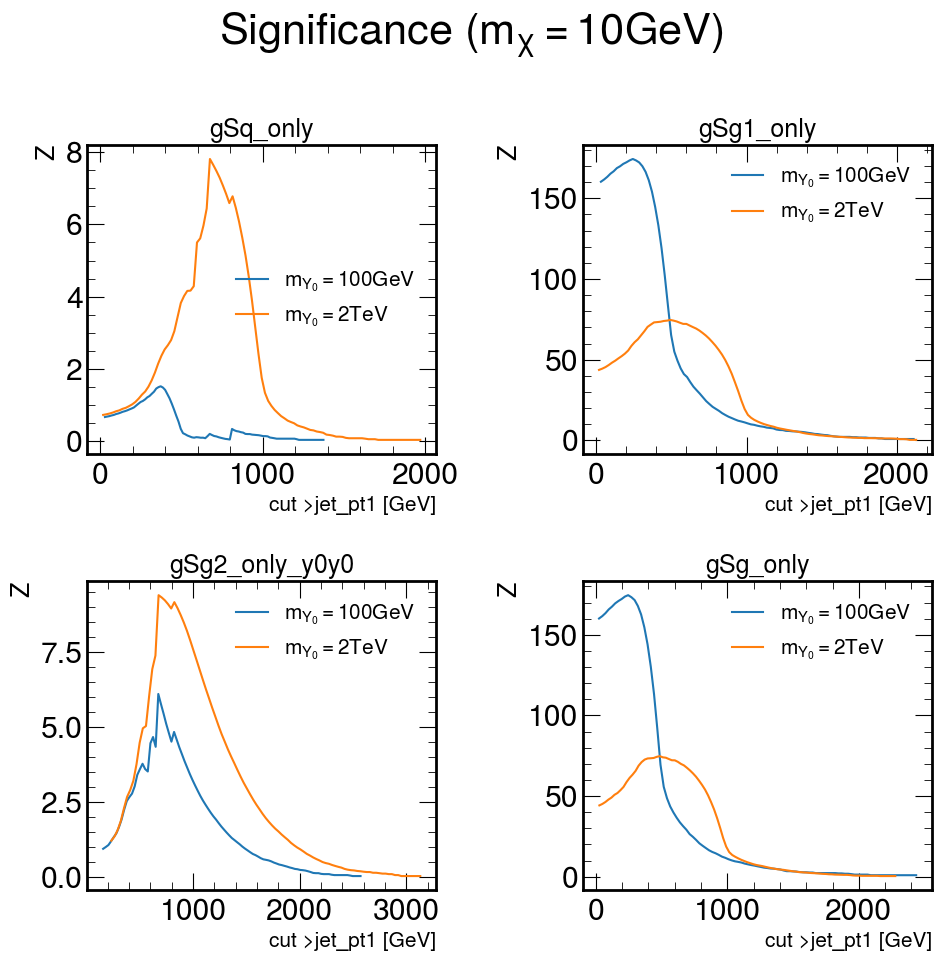

In [38]:
fig, ax = plt.subplots(2,2)

fig.suptitle(r"Significance ($m_{\chi} = 10$GeV)")

for i in range(2):
    ax[0,0].plot(pt_values[cases[0]][i], Z[cases[0]][i])
    ax[0,1].plot(pt_values[cases[1]][i], Z[cases[1]][i])
    ax[1,0].plot(pt_values[cases[2]][i], Z[cases[2]][i])
    ax[1,1].plot(pt_values[cases[3]][i], Z[cases[3]][i])
    ax[0,0].set_title(cases[0], fontsize=18)
    ax[0,1].set_title(cases[1], fontsize=18)
    ax[1,0].set_title(cases[2], fontsize=18)
    ax[1,1].set_title(cases[3], fontsize=18)

for i in range(2):
    for j in range(2):
        ax[i,j].legend([r"$m_{Y_{0}}=100$GeV",r"$m_{Y_{0}}=2$TeV"],fontsize=15)
        ax[i,j].set_xlabel("cut >jet_pt1 [GeV]",fontsize=15)
        ax[i,j].set_ylabel("Z",fontsize=18)
        #ax[i,j].set_xlim(0,2000)

fig.tight_layout()
plt.show()

In [39]:
Z, pt_values = find_significance(cases, data, [data_WpJ, data_ZpJ],
                                 cut_var='jet_pt1', use_weights=True, SG_weights=Weights,
                                 BG_weights=[Weights['WpJets'], Weights['ZpJets']],
                                 set_lims=True, lims=(0,1000), size=500)

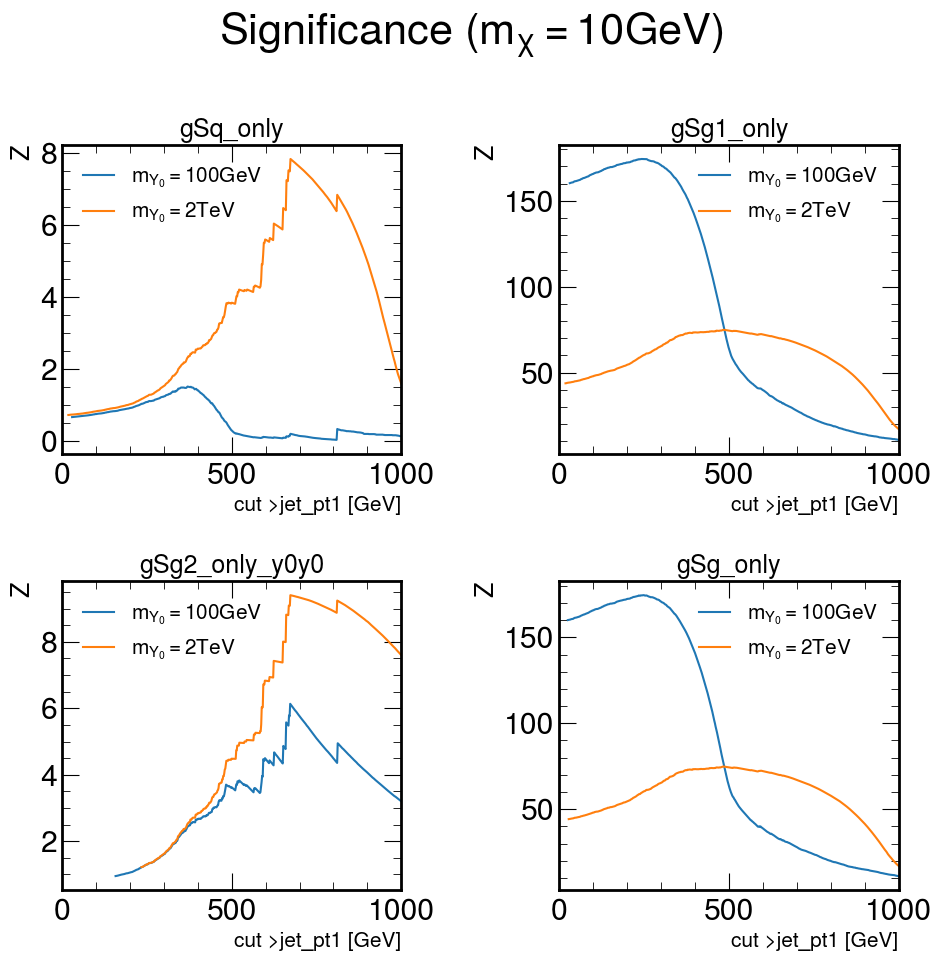

In [41]:
fig, ax = plt.subplots(2,2)

fig.suptitle(r"Significance ($m_{\chi} = 10$GeV)")

for i in range(2):
    ax[0,0].plot(pt_values[cases[0]][i], Z[cases[0]][i])
    ax[0,1].plot(pt_values[cases[1]][i], Z[cases[1]][i])
    ax[1,0].plot(pt_values[cases[2]][i], Z[cases[2]][i])
    ax[1,1].plot(pt_values[cases[3]][i], Z[cases[3]][i])
    ax[0,0].set_title(cases[0], fontsize=18)
    ax[0,1].set_title(cases[1], fontsize=18)
    ax[1,0].set_title(cases[2], fontsize=18)
    ax[1,1].set_title(cases[3], fontsize=18)

for i in range(2):
    for j in range(2):
        ax[i,j].legend([r"$m_{Y_{0}}=100$GeV",r"$m_{Y_{0}}=2$TeV"],fontsize=15)
        ax[i,j].set_xlabel("cut >jet_pt1 [GeV]",fontsize=15)
        ax[i,j].set_ylabel("Z",fontsize=18)
        ax[i,j].set_xlim(0,1000)

fig.tight_layout()
plt.show()

In [42]:
cuts = get_cuts(cases, Z, pt_values, "jet_pt1", "GeV", ["my0=100GeV", "my0=2TeV"], printResults=True)

case : gSq_only
	mass point: my0=100GeV
		max significance: 1.5215395436011234
		cut: jet_pt1 > 369.703GeV
	mass point: my0=2TeV
		max significance: 7.8260064345988685
		cut: jet_pt1 > 673.408GeV
case : gSg1_only
	mass point: my0=100GeV
		max significance: 174.37838480185462
		cut: jet_pt1 > 246.186GeV
	mass point: my0=2TeV
		max significance: 74.89727607749377
		cut: jet_pt1 > 484.379GeV
case : gSg2_only_y0y0
	mass point: my0=100GeV
		max significance: 6.135319651136848
		cut: jet_pt1 > 672.455GeV
	mass point: my0=2TeV
		max significance: 9.403721671651395
		cut: jet_pt1 > 672.985GeV
case : gSg_only
	mass point: my0=100GeV
		max significance: 174.58620243995756
		cut: jet_pt1 > 247.596GeV
	mass point: my0=2TeV
		max significance: 74.84085966895556
		cut: jet_pt1 > 483.51GeV


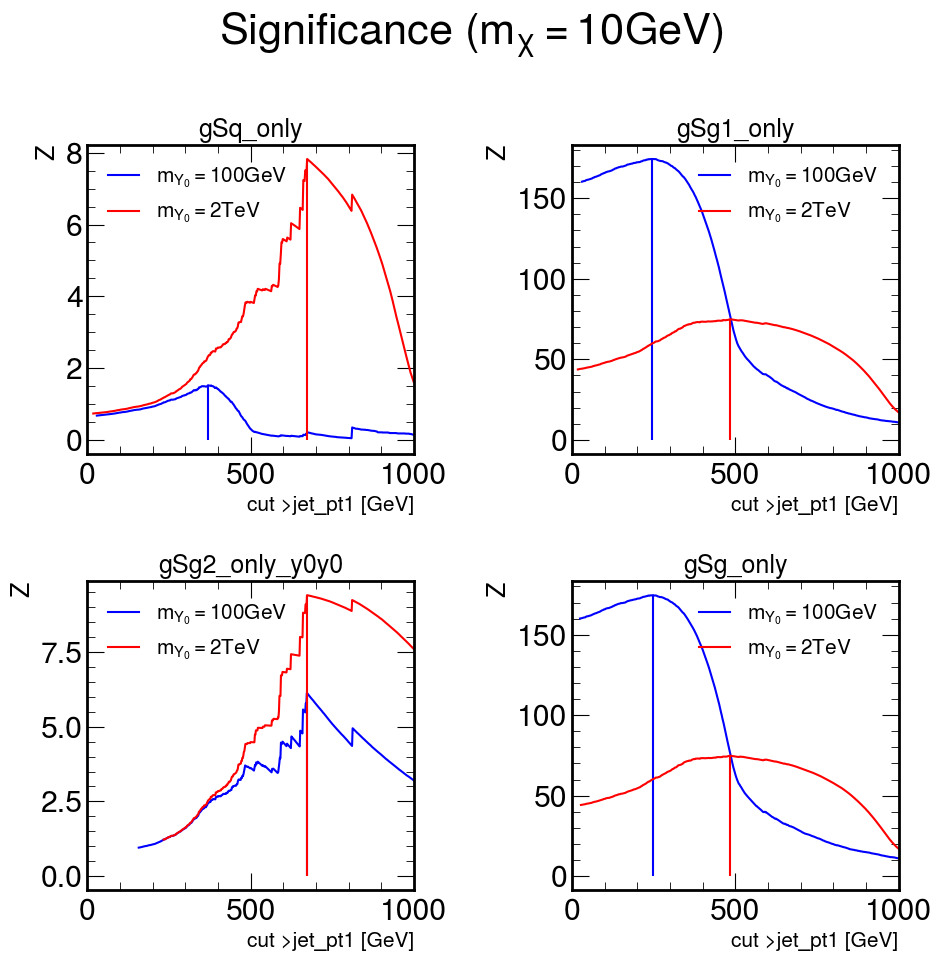

In [43]:
fig, ax = plt.subplots(2,2)

fig.suptitle(r"Significance ($m_{\chi} = 10$GeV)")

colors = ["b","r"]
labels = [r"$m_{Y_{0}}=100$GeV",r"$m_{Y_{0}}=2$TeV"]

for i in range(2):
    ax[0,0].plot(pt_values[cases[0]][i], Z[cases[0]][i],color=colors[i], label=labels[i])
    ax[0,1].plot(pt_values[cases[1]][i], Z[cases[1]][i],color=colors[i], label=labels[i])
    ax[1,0].plot(pt_values[cases[2]][i], Z[cases[2]][i],color=colors[i], label=labels[i])
    ax[1,1].plot(pt_values[cases[3]][i], Z[cases[3]][i],color=colors[i], label=labels[i])
    ax[0,0].set_title(cases[0], fontsize=18)
    ax[0,1].set_title(cases[1], fontsize=18)
    ax[1,0].set_title(cases[2], fontsize=18)
    ax[1,1].set_title(cases[3], fontsize=18)
    ax[0,0].vlines(cuts[cases[0]][i], ymin=0, ymax=max(Z[cases[0]][i]),color=colors[i])
    ax[0,1].vlines(cuts[cases[1]][i], ymin=0, ymax=max(Z[cases[1]][i]),color=colors[i])
    ax[1,0].vlines(cuts[cases[2]][i], ymin=0, ymax=max(Z[cases[2]][i]),color=colors[i])
    ax[1,1].vlines(cuts[cases[3]][i], ymin=0, ymax=max(Z[cases[3]][i]),color=colors[i])

for i in range(2):
    for j in range(2):
        ax[i,j].legend(fontsize=15)
        ax[i,j].set_xlabel("cut >jet_pt1 [GeV]",fontsize=15)
        ax[i,j].set_ylabel("Z",fontsize=18)
        ax[i,j].set_xlim(0,1000)

fig.tight_layout()
plt.show()

In [44]:
cut_data = {}
dataWpJ_cut = {}
dataZpJ_cut = {}
for i in cases:
    cut_data[i] = []
    dataWpJ_cut[i] = []
    dataZpJ_cut[i] = []
    for j in range(2):
        cut_data[i].append(data[i][j][data[i][j]['jet_pt0'] > cuts[i][j]].copy())
        dataWpJ_cut[i].append(data_WpJ[data_WpJ['jet_pt0'] > cuts[i][j]].copy())
        dataZpJ_cut[i].append(data_ZpJ[data_ZpJ['jet_pt0'] > cuts[i][j]].copy())
        #cut_data2[i].append(data[i][j][data[i][j]['jet_pt0'] > 300].copy()) # jet_pt0 > 300GeV
        #dataWpJ_cut2[i].append(data_WpJ[data_WpJ['jet_pt0'] > 300].copy()) # jet_pt0 > 300GeV
        #dataZpJ_cut2[i].append(data_ZpJ[data_ZpJ['jet_pt0'] > 300].copy()) # jet_pt0 > 300GeV

In [46]:
print("Número de Eventos para cada caso:")
print("\tOriginal")
print("Modelos: ",[[data[i][j].shape[0] for j in range(2)] for i in cases])
print("WpJets + ZpJets: ",[data_WpJ.shape[0], data_ZpJ.shape[0]])
print("\tCut")
print("Modelos: ",[[cut_data[i][j].shape[0] for j in range(2)] for i in cases])
print("WpJets: ",[[dataWpJ_cut[i][j].shape[0] for j in range(2)] for i in cases])
print("ZpJets: ",[[dataZpJ_cut[i][j].shape[0] for j in range(2)] for i in cases])
print("\nOrden: ","gSg_only", "gSg1_only", "gSg2_only_y0y0", "gSq_only")

Número de Eventos para cada caso:
	Original
Modelos:  [[44350, 48842], [45453, 49050], [49951, 50000], [45421, 49136]]
WpJets + ZpJets:  [522, 699]
	Cut
Modelos:  [[39804, 40074], [45453, 46422], [36226, 49616], [45421, 46441]]
WpJets:  [[233, 14], [522, 72], [14, 14], [522, 73]]
ZpJets:  [[323, 14], [699, 86], [15, 14], [699, 88]]

Orden:  gSg_only gSg1_only gSg2_only_y0y0 gSq_only


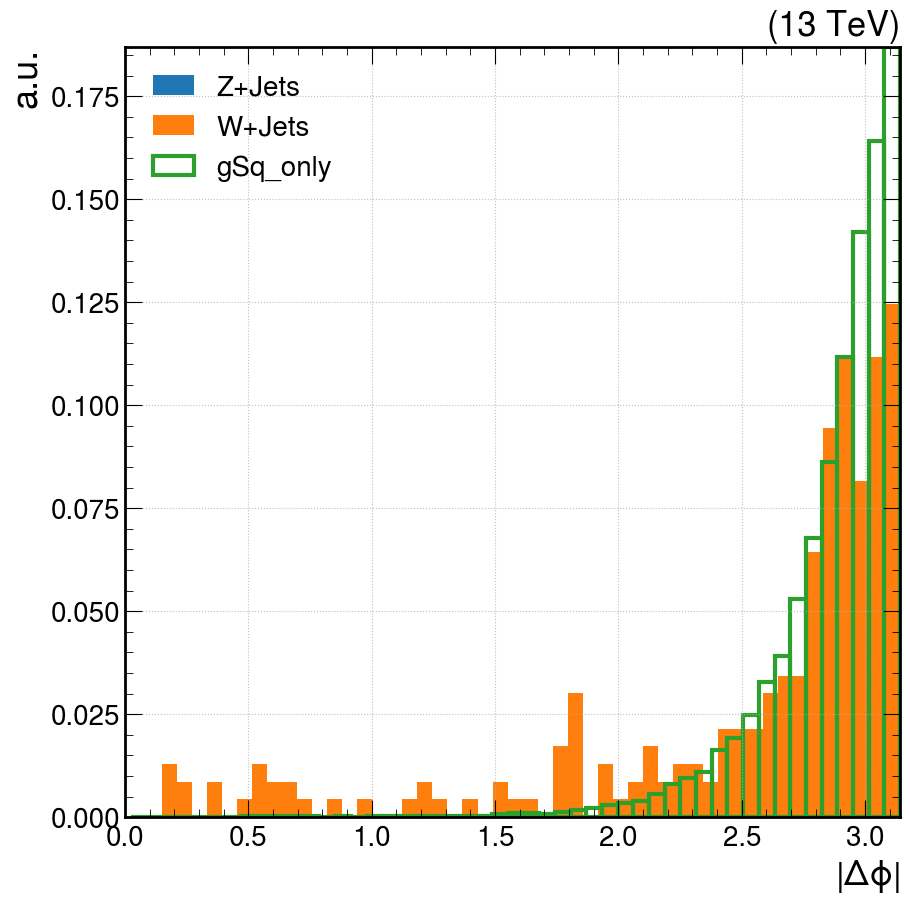

/home/juan/Documents/GitHub/VBFDM_EAFIT/funcs.py:121: RuntimeWarning: invalid value encountered in sqrt
  m = np.sqrt(
/home/juan/Documents/GitHub/VBFDM_EAFIT/funcs.py:121: RuntimeWarning: invalid value encountered in sqrt
  m = np.sqrt(


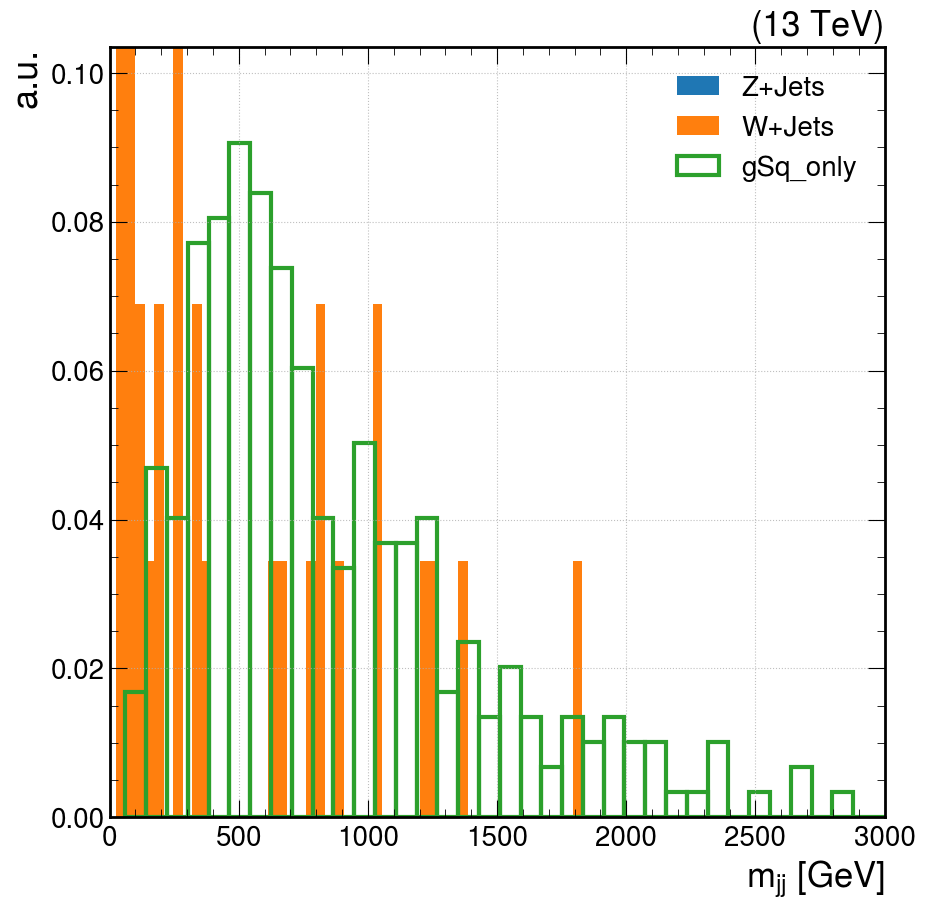

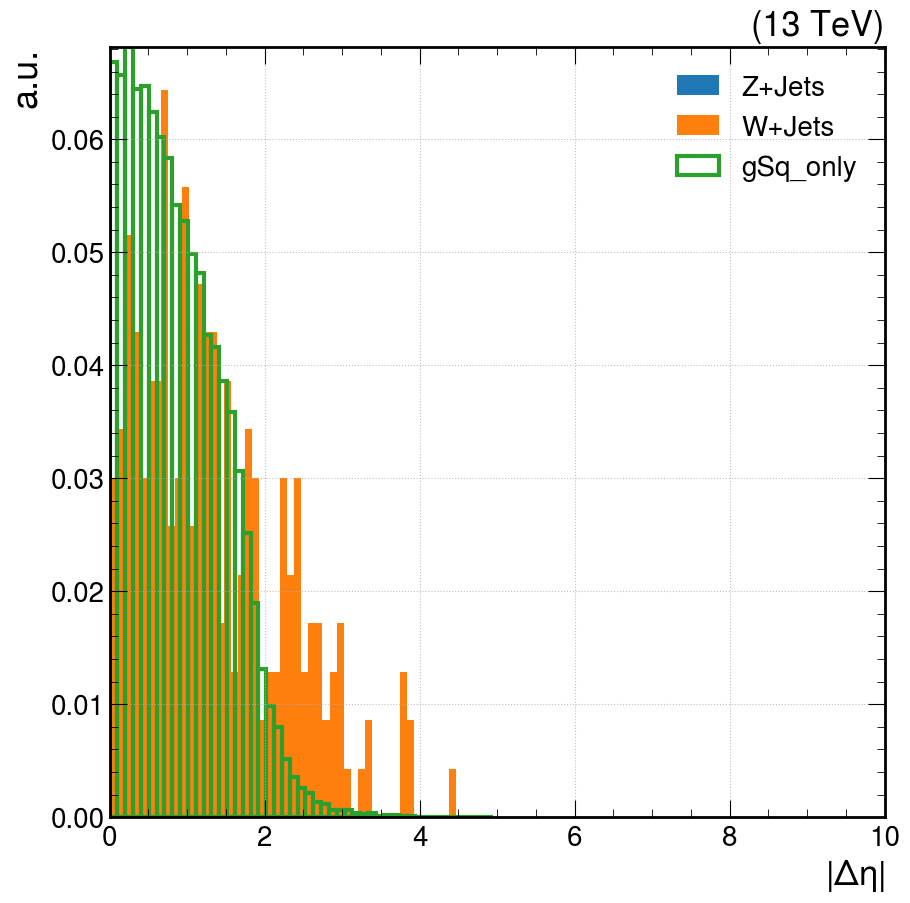

In [47]:
datas = [dataWpJ_cut['gSq_only'][0], dataWpJ_cut['gSq_only'][0], cut_data['gSq_only'][0]]
names = ['Z+Jets','W+Jets','gSq_only']
plotObservable(datas, names, 'Azim_diff', save=False, plot=True)
plotObservable(datas, names, 'Inv_mass', save=False, plot=True)
plotObservable(datas, names, 'Pseudorapidity', save=False, plot=True)

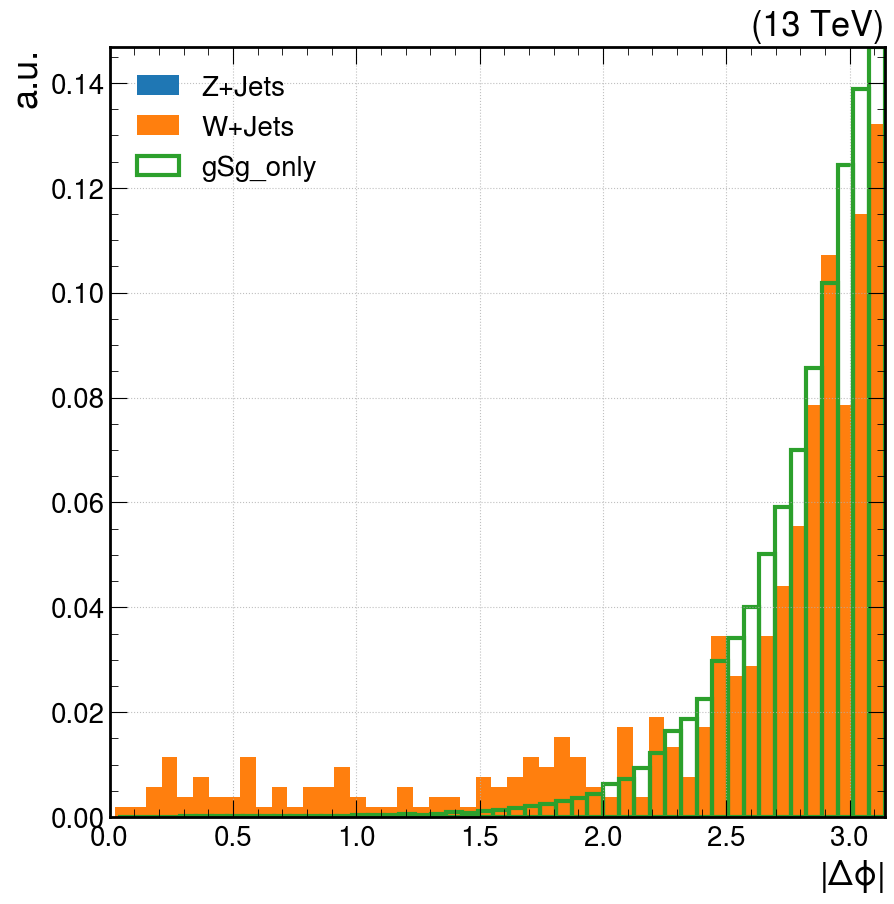

/home/juan/Documents/GitHub/VBFDM_EAFIT/funcs.py:121: RuntimeWarning: invalid value encountered in sqrt
  m = np.sqrt(
/home/juan/Documents/GitHub/VBFDM_EAFIT/funcs.py:121: RuntimeWarning: invalid value encountered in sqrt
  m = np.sqrt(


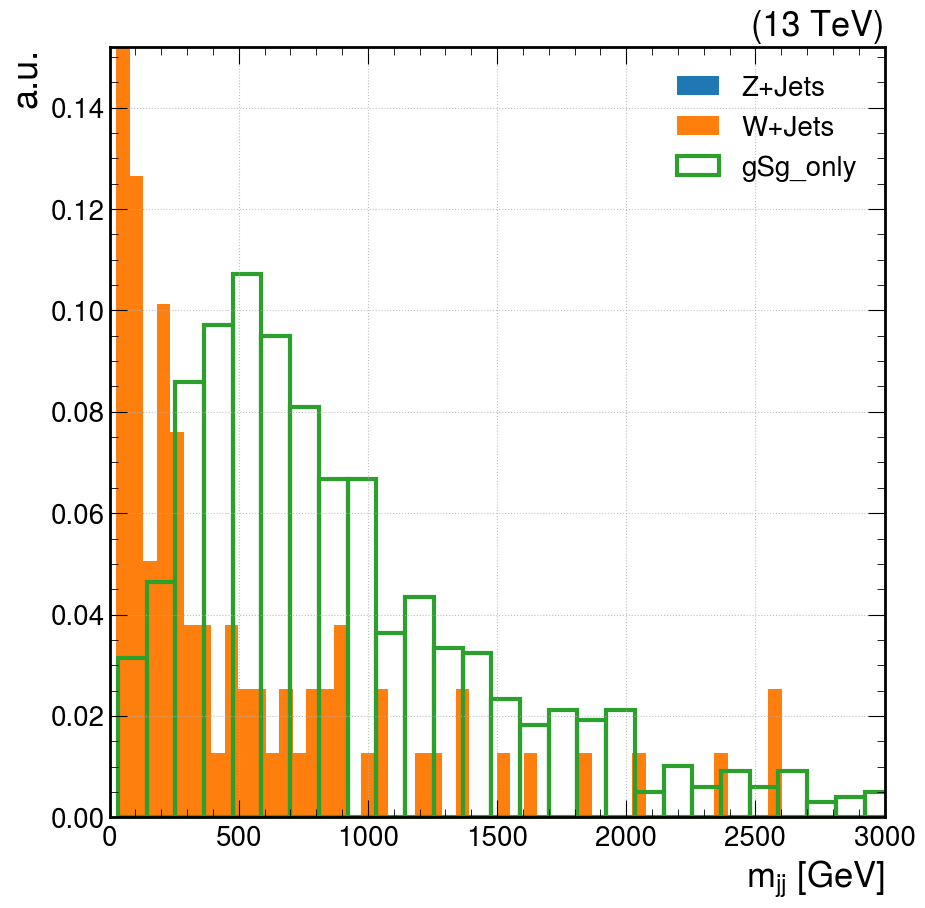

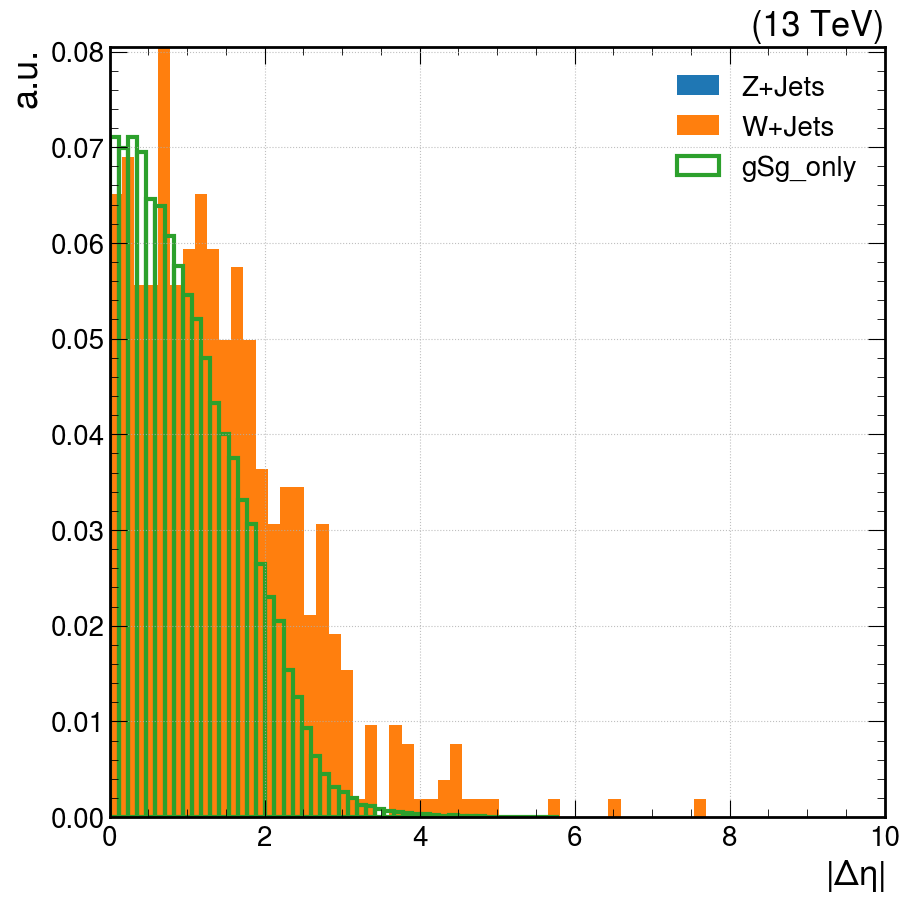

In [48]:
datas = [dataWpJ_cut['gSg_only'][0], dataWpJ_cut['gSg_only'][0], cut_data['gSg_only'][0]]
names = ['Z+Jets','W+Jets','gSg_only']
plotObservable(datas, names, 'Azim_diff', save=False, plot=True)
plotObservable(datas, names, 'Inv_mass', save=False, plot=True)
plotObservable(datas, names, 'Pseudorapidity', save=False, plot=True)